# Predicting Home Sale Prices

## The Problem

**Kaggle is a data science platform that hosts various machine learning competitions. A popular competition is their House Price Prediction competition which has no end date, and is a great competition to practice advanced regression techniques in machine learning. This is a participation in that project in order to test out various experiments that may improve a linear regression model.**

# The Data

**The dataset is provided by the hosts of the competition and includes a large set of property sales records. There are numerous features stored in a csv format. A codebook is provided on the competition home page which is used to identify variable meanings for each feature. You can find that codebook [Here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)**

## Regression

**Home Prices are continuous values, which make this project a perfect candidate to utilize regression techniques. Regression is the process of fitting a line to data that minimizes the distances of all data points to that line. The target values are always a continuous value. The predictors must be numerical values since the process of regression is fitting a line to datapoints and therefore the predictors lie on the x axis. A good regression line will have a high R-Squared value indicating that the independent values explain a large amount of variation in the data. R-squared ranges from 0 to 1. The most important things to consider when utilizing linear regression are the assumptions. Those assumptions are as follows:**
-   There exists a linear relationship between the independent and dependent variable
-   There is no correlation between independent variables
-   There is a normal distribution of the dependent variable for every independent variable
-   There is a constant variance

In [258]:
#%pip install scipy
#%pip install seaborn
#%pip install matplotlib
#%pip install statsmodels

In [259]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats
import statsmodels.api as sma
import sklearn.linear_model
import numpy as np

In [260]:
pd.options.display.max_rows=90
pd.options.display.max_columns=5

# Experiment 1

## Data Understanding (EDA) and Pre-Processing

In [261]:
#bringing in datasets provided by the Kaggle Competition
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Get first look at data

In [262]:
train.shape

(1460, 81)

In [263]:
train.head()

,Id,MSSubClass,...,SaleCondition,SalePrice
0,1,60,...,Normal,208500
1,2,20,...,Normal,181500
2,3,60,...,Normal,223500
3,4,70,...,Abnorml,140000
4,5,60,...,Normal,250000


### **There are 81 features in this dataset, so there should not be a lot of feature engineering necessary. I immediately notice a lot of missing values, so I will first make some pre-processing decisions for those**

In [264]:
train.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [265]:
#Get a List of every column containing Null Values
train.columns[train.isna().sum() > 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

### **The Codebook explains that the null values for some of these columns actually indicate the absense of that specific feature. This is meaningful and therefore all those null values will be replaced with 'None' to eliminate the null value and keep the interpretation. Those columns are as follows:**
-   'Alley'
-   'BsmtQual'
-   'BsmtCond'
-   'BsmtExposure'
-   'BsmtFinType1'
-   'BsmtFinType2'
-   'FireplaceQu'
-   'GarageType'
-   'GarageFinish'
-   'GarageQual'
-   'GarageCond'
-   'PoolQC'
-   'Fence'
-   'MiscFeature'

### **The columns that contain null values and are actually considered missing values are as follows:**
-   'LotFrontage'
-   'MasVnrType'
-   'MasVnrArea'
-   'Electrical'
-   'GarageYrBlt'

### **GarageYrBlt is a continuos variable, however if there is no garage then this value will be missing. Since it is not a categorical value, I can not simply replace the missing value with 'None', but I also do not want to replace the value with a mean/mode/or 0 because it would not be an accurate representation of that observation. Let's look to see exactly how many datapoints have null values for this feature**

In [266]:
train[train['GarageYrBlt'].isna()].shape

(81, 81)

In [267]:
train['GarageYrBlt'].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

### **There are 81 observations with null values for GarageYrBlt. While, it is not ideal to lose observations I will drop these values in order to perserve the integrity of this feature**

In [268]:
#Make a copy of the dataset for this experiment and drop missing values for GarageYrBlt
train_exp1 = train.dropna(subset='GarageYrBlt')
train_exp1.shape

(1379, 81)

### **Now I will fill in the null values with 'Null' just for the categorical columns where the null's are meaningful**

In [269]:
#Replace NA's with 'None'
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    train_exp1.loc[:,column].fillna('None', inplace=True)

C:\Users\Tonyj\AppData\Local\Temp\ipykernel_21284\686905559.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_exp1.loc[:,column].fillna('None', inplace=True)


In [270]:
train_exp1['PoolQC'].unique()

array(['None', 'Ex', 'Fa', 'Gd'], dtype=object)

In [271]:
train_exp1['PoolQC'].isna().sum()

0

### **Now I want to replace the remaining columns that have NA's with the mode for categoricals and mean for numericals. This perserves observations and assumes the most generalized value of the feature**

In [272]:
#Fill Na's with Mean and Mode
for column in[
    'MasVnrType',
    'Electrical'
]:
    train_exp1.loc[:,column].fillna(train_exp1[column].mode()[0], inplace=True)

for column in[
    'LotFrontage',
    'MasVnrArea'
]:
    train_exp1.loc[:,column].fillna(train_exp1[column].mean(), inplace=True)

C:\Users\Tonyj\AppData\Local\Temp\ipykernel_21284\1745826991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_exp1.loc[:,column].fillna(train_exp1[column].mode()[0], inplace=True)
C:\Users\Tonyj\AppData\Local\Temp\ipykernel_21284\1745826991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_exp1.loc[:,column].fillna(train_exp1[column].mode()[0], inplace=True)
C:\Users\Tonyj\AppData\Local\Temp\ipykernel_21284\1745826991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [273]:
mode=train_exp1['MasVnrType'].unique()
mode

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

In [274]:
train_exp1['LotFrontage'].isna().sum()

0

In [275]:
train_exp1.columns[train_exp1.isna().sum() > 0]

Index([], dtype='object')

In [276]:
train_exp1.shape

(1379, 81)

## Look at correlations

### **One of the assumptions of the linear model is that the predictor variables are not correlated, so I will drop all numerical values that have a moderate to high correlation with each other**

<AxesSubplot: title={'center': 'Correlations Between Numerical Variables'}>

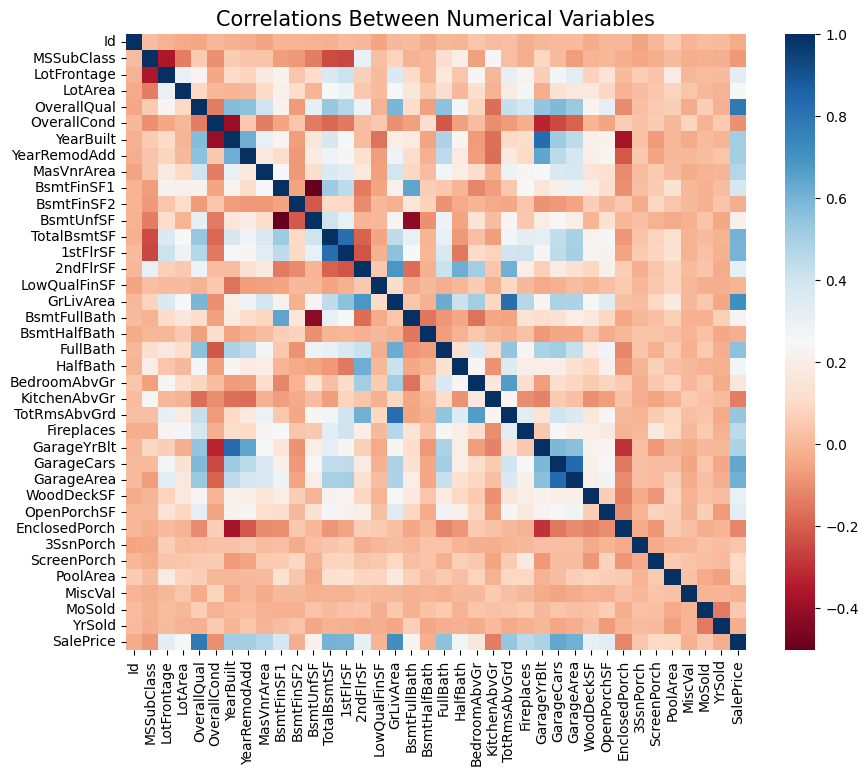

In [277]:
plt.figure(figsize=(10,8))
plt.title("Correlations Between Numerical Variables", size=15)
plt.rc('axes', labelsize=50)
sns.heatmap(train_exp1.corr(), cmap='RdBu')

### **First I need to create a dataframe with all the correlations, and then I will replace all values of 1 with 0, because I want to go through each column and remove any feature that has a correlation above .30 (Which is considered to be Medium correlation). If I left the 1's in there, then eventually every column would be removed because every column is correlated with itself**

In [278]:
#Replacing 1's with 0's
corr = train_exp1.corr()
pd.DataFrame(corr)

for col in corr.columns:
    i = 0
    for row in corr[col]:
        if row == 1:
            corr.replace(to_replace = row, value=0, inplace=True)
        i = i+1

corr

,Id,MSSubClass,...,YrSold,SalePrice
Id,0.000000,0.019529,...,0.008721,-0.027636
MSSubClass,0.019529,0.000000,...,-0.023073,-0.077707
LotFrontage,-0.010538,-0.357813,...,0.011065,0.329231
LotArea,-0.035147,-0.136092,...,-0.013797,0.252921
OverallQual,-0.041980,0.050092,...,-0.019273,0.787228
OverallCond,0.007146,-0.097027,...,0.050309,-0.095278
YearBuilt,-0.020228,0.060041,...,-0.006809,0.507584
YearRemodAdd,-0.025519,0.036926,...,0.039937,0.505434
MasVnrArea,-0.053860,0.033710,...,-0.004713,0.465827
BsmtFinSF1,-0.004083,-0.067904,...,0.017754,0.375563


In [279]:
#Getting the absolute value of all correlations
for col in corr.columns:
    for row in corr[col]:
        corr.replace(to_replace = row, value=abs(row), inplace=True)

corr

,Id,MSSubClass,...,YrSold,SalePrice
Id,0.000000,0.019529,...,0.008721,0.027636
MSSubClass,0.019529,0.000000,...,0.023073,0.077707
LotFrontage,0.010538,0.357813,...,0.011065,0.329231
LotArea,0.035147,0.136092,...,0.013797,0.252921
OverallQual,0.041980,0.050092,...,0.019273,0.787228
OverallCond,0.007146,0.097027,...,0.050309,0.095278
YearBuilt,0.020228,0.060041,...,0.006809,0.507584
YearRemodAdd,0.025519,0.036926,...,0.039937,0.505434
MasVnrArea,0.053860,0.033710,...,0.004713,0.465827
BsmtFinSF1,0.004083,0.067904,...,0.017754,0.375563


In [280]:
#Find which variables are correlated with each other to make selections
corr_frame = pd.DataFrame
list = []
for col in corr.columns:
    new_list = [col]
    new_list.append(corr.index[corr[col]>=.30].tolist())
    list.append(new_list)

pd.DataFrame(list)

,0,1
0,Id,[]
1,MSSubClass,"[LotFrontage, 2ndFlrSF]"
2,LotFrontage,"[MSSubClass, LotArea, TotalBsmtSF, 1stFlrSF, G..."
3,LotArea,[LotFrontage]
4,OverallQual,"[YearBuilt, YearRemodAdd, MasVnrArea, BsmtUnfS..."
5,OverallCond,"[YearBuilt, GarageYrBlt]"
6,YearBuilt,"[OverallQual, OverallCond, YearRemodAdd, MasVn..."
7,YearRemodAdd,"[OverallQual, YearBuilt, FullBath, GarageYrBlt..."
8,MasVnrArea,"[OverallQual, YearBuilt, TotalBsmtSF, 1stFlrSF..."
9,BsmtFinSF1,"[BsmtUnfSF, TotalBsmtSF, 1stFlrSF, BsmtFullBat..."


### **The above DataFrame admittedly is not pretty, but the idea behind it is for me to select which features I want to drop. **

### ***I'm going to start dropping variables that are correlated until there are none left*

In [281]:
#Getting correlated features with 'LotFrontage'
list[2][1]

['MSSubClass',
 'LotArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'SalePrice']

In [282]:
#Drop first set of correlated independents
corr2 = corr.drop(columns=['MSSubClass', 'LotArea', 'TotalBsmtSF', '1stFlrSF',
    'GrLivArea',
    'TotRmsAbvGrd',
    'GarageArea'])
corr2 = corr2.drop(['MSSubClass', 'LotArea', 'TotalBsmtSF', '1stFlrSF',
    'GrLivArea',
    'TotRmsAbvGrd',
    'GarageArea'])

# Find remaining correlated independents
corr_frame = pd.DataFrame
list = []
for col in corr2.columns:
    new_list = [col]
    new_list.append(corr2.index[corr2[col]>=.30].tolist())
    list.append(new_list)

pd.DataFrame(list)

,0,1
0,Id,[]
1,LotFrontage,[SalePrice]
2,OverallQual,"[YearBuilt, YearRemodAdd, MasVnrArea, BsmtUnfS..."
3,OverallCond,"[YearBuilt, GarageYrBlt]"
4,YearBuilt,"[OverallQual, OverallCond, YearRemodAdd, MasVn..."
5,YearRemodAdd,"[OverallQual, YearBuilt, FullBath, GarageYrBlt..."
6,MasVnrArea,"[OverallQual, YearBuilt, GarageCars, SalePrice]"
7,BsmtFinSF1,"[BsmtUnfSF, BsmtFullBath, SalePrice]"
8,BsmtFinSF2,[]
9,BsmtUnfSF,"[OverallQual, BsmtFinSF1, BsmtFullBath]"


In [283]:
#Getting correlated features with 'YearBuilt'
list[4][1]

['OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'FullBath',
 'GarageYrBlt',
 'GarageCars',
 'EnclosedPorch',
 'SalePrice']

In [284]:
#Drop second set of correlated independents
corr2 = corr2.drop(columns=['OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'FullBath',
 'GarageYrBlt',
 'GarageCars',
 'EnclosedPorch'])
corr2 = corr2.drop(['OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 'FullBath',
 'GarageYrBlt',
 'GarageCars',
 'EnclosedPorch'])

# Find remaining correlated independents
corr_frame = pd.DataFrame
list = []
for col in corr2.columns:
    new_list = [col]
    new_list.append(corr2.index[corr2[col]>=.30].tolist())
    list.append(new_list)

pd.DataFrame(list)

,0,1
0,Id,[]
1,LotFrontage,[SalePrice]
2,YearBuilt,[SalePrice]
3,BsmtFinSF1,"[BsmtUnfSF, BsmtFullBath, SalePrice]"
4,BsmtFinSF2,[]
5,BsmtUnfSF,"[BsmtFinSF1, BsmtFullBath]"
6,2ndFlrSF,"[HalfBath, BedroomAbvGr, SalePrice]"
7,LowQualFinSF,[]
8,BsmtFullBath,"[BsmtFinSF1, BsmtUnfSF]"
9,BsmtHalfBath,[]


In [285]:
#Getting correlated features with '2ndFlrSF'
list[6][1]

['HalfBath', 'BedroomAbvGr', 'SalePrice']

In [286]:
#Drop third set of correlated independents
corr2 = corr2.drop(columns=['HalfBath', 'BedroomAbvGr'])
corr2 = corr2.drop(['HalfBath', 'BedroomAbvGr'])

# Find remaining correlated independents
corr_frame = pd.DataFrame
list = []
for col in corr2.columns:
    new_list = [col]
    new_list.append(corr2.index[corr2[col]>=.30].tolist())
    list.append(new_list)

pd.DataFrame(list)

,0,1
0,Id,[]
1,LotFrontage,[SalePrice]
2,YearBuilt,[SalePrice]
3,BsmtFinSF1,"[BsmtUnfSF, BsmtFullBath, SalePrice]"
4,BsmtFinSF2,[]
5,BsmtUnfSF,"[BsmtFinSF1, BsmtFullBath]"
6,2ndFlrSF,[SalePrice]
7,LowQualFinSF,[]
8,BsmtFullBath,"[BsmtFinSF1, BsmtUnfSF]"
9,BsmtHalfBath,[]


In [287]:
#Getting correlated features with 'BsmtFinSf1'
list[3][1]

['BsmtUnfSF', 'BsmtFullBath', 'SalePrice']

In [288]:
#Drop fourth set of correlated independents
corr2 = corr2.drop(columns=['BsmtUnfSF', 'BsmtFullBath'])
corr2 = corr2.drop(['BsmtUnfSF', 'BsmtFullBath'])

# Find remaining correlated independents
corr_frame = pd.DataFrame
list = []
for col in corr2.columns:
    new_list = [col]
    new_list.append(corr2.index[corr2[col]>=.30].tolist())
    list.append(new_list)

pd.DataFrame(list)

,0,1
0,Id,[]
1,LotFrontage,[SalePrice]
2,YearBuilt,[SalePrice]
3,BsmtFinSF1,[SalePrice]
4,BsmtFinSF2,[]
5,2ndFlrSF,[SalePrice]
6,LowQualFinSF,[]
7,BsmtHalfBath,[]
8,KitchenAbvGr,[]
9,Fireplaces,[SalePrice]


### **Awesome! Now I have removed all redundant numerical features that might have caused problems in the model. I will select only those to add as independants**

In [289]:
feature_list = pd.DataFrame(list)
my_features = feature_list[0].unique()
my_features

array(['Id', 'LotFrontage', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SalePrice'], dtype=object)

## Scaling

In [290]:
# Establishing X and Y

#Select all the categorical features first
X = train_exp1.select_dtypes('object')

#Add all the numerical feautres that we found to use as independants
for col in my_features:
    X[col] = train_exp1[col]

y = train_exp1['SalePrice']

#Look at the X dataframe
X

,MSZoning,Street,...,YrSold,SalePrice
0,RL,Pave,...,2008,208500
1,RL,Pave,...,2007,181500
2,RL,Pave,...,2008,223500
3,RL,Pave,...,2006,140000
4,RL,Pave,...,2008,250000
...,...,...,...,...,...
1455,RL,Pave,...,2007,175000
1456,RL,Pave,...,2010,210000
1457,RL,Pave,...,2010,266500
1458,RL,Pave,...,2010,142125


In [291]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(X.select_dtypes(np.number))

#put into a df
X_scaled = pd.DataFrame(scaled,columns = X.select_dtypes(np.number).columns)

#Add Categoricals back into the dataframe
for categorical in X.select_dtypes('object').columns:
    X_scaled[categorical] = X[categorical]

#Look at the new Scaled DataFrame
X_scaled

,Id,LotFrontage,...,SaleType,SaleCondition
0,-1.736442,-0.259232,...,WD,Normal
1,-1.734066,0.424971,...,WD,Normal
2,-1.731691,-0.122392,...,WD,Normal
3,-1.729315,-0.487300,...,WD,Abnorml
4,-1.726939,0.607425,...,WD,Normal
...,...,...,...,...,...
1374,1.720384,-0.396073,...,WD,Normal
1375,1.722759,0.653038,...,New,Partial
1376,1.725135,-0.213619,...,WD,Normal
1377,1.727511,-0.122392,...,WD,Normal


## **I want to create dummy variables for the categoricals because the Linear model will only take numerical values**

In [292]:
X_1 = pd.get_dummies(X_scaled, columns=X_scaled.select_dtypes(['object']).columns,drop_first=True)
X_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Columns: 235 entries, Id to SaleCondition_Partial
dtypes: float64(19), uint8(216)
memory usage: 495.7 KB


## Modeling

### **Now that null values are taken care of, independents are scaled and shown to have no correlation, and categoricals have been converted to binary variables, I can start training the linear model**

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.3, random_state = 7)

In [294]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape


((965, 235), (965,), (414, 235), (414,))

In [295]:
from sklearn.linear_model import LinearRegression

In [296]:

lr = LinearRegression()

In [297]:
lr_m = lr.fit(X_train, y_train)

In [298]:
#Model Summary
X_c = sma.add_constant(X_train)

#Create OLS model and fit it
est = sma.OLS(y_train.values.reshape(-1,1), X_c)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.470e+28
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:05:03   Log-Likelihood:                 19284.
No. Observations:                 965   AIC:                        -3.812e+04
Df Residuals:                     743   BIC:                        -3.704e+04
Df Model:                         221                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.855e+

### Wow! The R-Squared value is extremely high, If this is true, that means that the features that I used explain 100% of the variation in Home Prices

In [299]:
#Get our coefficient of determination
print('Coefficient of Determination:',lr.score(X_test, y_test))

Coefficient of Determination: 0.9999998967549506


In [300]:
#creates table to show the features and their coefficients 
coeff_df = pd.DataFrame(lr.coef_, X_test.columns, columns=['Coefficients'])
coeff_df

,Coefficients
Id,1.031661e-11
LotFrontage,1.273293e-11
YearBuilt,-5.456968e-12
BsmtFinSF1,-1.091394e-11
BsmtFinSF2,2.910383e-11
...,...
SaleCondition_AdjLand,-3.910827e-11
SaleCondition_Alloca,-3.183231e-11
SaleCondition_Family,-9.777068e-12
SaleCondition_Normal,7.958079e-13


## Testing the model

In [301]:
y_pred = lr_m.predict(X_test)

In [302]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred,squared = False)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', rmse)

Mean Absolute Error: 3.5309269444689106
Mean Square Error: 767.19237917167
Root Mean Square Error: 27.698237835134385


In [332]:
train_exp1['SalePrice'].describe()

count      1379.00000
mean     185479.51124
std       79023.89060
min       35311.00000
25%      134000.00000
50%      167500.00000
75%      217750.00000
max      755000.00000
Name: SalePrice, dtype: float64

### **So the Mean Square Error says the predictions are off by about $767 of the actual home price. This is not too bad, considering some home prices are in the hundred thousands. However, minimizing this error would be nice. Let's see what else could be done**

## Experiment 2

In [303]:
train.select_dtypes('object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### **Here I'm looking at all the categorical columns. I want to see if any of them would be best coded in a different manner. There are some categoricals that are ordinal and I will see if recoding them on a numerical scale improves the performance instead of using those as dummy columns. To identify the ordinal features, I manually searched the codebook for every categorical feature to understand the variables**

In [304]:
#Making a list of Ordinal Features simply for reference
ordinals = ['LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence']

### **Starting with a clean dataset before the scaling was performed previously**

In [305]:
#Select all the categorical features first
X2 = train_exp1.select_dtypes('object')

#Add all the numerical feautres that we found to use as independants
for col in my_features:
    X2[col] = train_exp1[col]

#Make sure no nulls are present
X2.isnull().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
Id               0
LotFrontage      0
YearBuilt        0
BsmtFinSF1       0
BsmtFinSF2       0
2ndFlrSF         0
LowQualFinSF     0
BsmtHalfBath     0
KitchenAbvGr     0
Fireplaces  

In [306]:
#Recoding Ordinal Variables
X2[X2['LandSlope']=='Gtl'] = 1
X2[X2['LandSlope']=='Mod'] = 2
X2[X2['LandSlope']=='Sev'] = 3

X2[X2['ExterQual']=='Ex'] = 5
X2[X2['ExterQual']=='Gd'] = 4
X2[X2['ExterQual']=='TA'] = 3
X2[X2['ExterQual']=='Fa'] = 2
X2[X2['ExterQual']=='Po'] = 1

X2[X2['ExterCond']=='Ex'] = 5
X2[X2['ExterCond']=='Gd'] = 4
X2[X2['ExterCond']=='TA'] = 3
X2[X2['ExterCond']=='Fa'] = 2
X2[X2['ExterCond']=='Po'] = 1

X2[X2['BsmtQual']=='Ex'] = 6
X2[X2['BsmtQual']=='Gd'] = 5
X2[X2['BsmtQual']=='TA'] = 4
X2[X2['BsmtQual']=='Fa'] = 3
X2[X2['BsmtQual']=='Po'] = 2
X2[X2['BsmtQual']=='None'] = 1

X2[X2['BsmtCond']=='Ex'] = 6
X2[X2['BsmtCond']=='Gd'] = 5
X2[X2['BsmtCond']=='TA'] = 4
X2[X2['BsmtCond']=='Fa'] = 3
X2[X2['BsmtCond']=='Po'] = 2
X2[X2['BsmtCond']=='None'] = 1

X2[X2['BsmtExposure']=='Gd'] = 5
X2[X2['BsmtExposure']=='Av'] = 4
X2[X2['BsmtExposure']=='Mn'] = 3
X2[X2['BsmtExposure']=='No'] = 2
X2[X2['BsmtExposure']=='None'] = 1

X2[X2['BsmtFinType1']=='GLQ'] = 7
X2[X2['BsmtFinType1']=='ALQ'] = 6
X2[X2['BsmtFinType1']=='BLQ'] = 5
X2[X2['BsmtFinType1']=='Rec'] = 4
X2[X2['BsmtFinType1']=='LwQ'] = 3
X2[X2['BsmtFinType1']=='Unf'] = 2
X2[X2['BsmtFinType1']=='None'] = 1

X2[X2['BsmtFinType2']=='GLQ'] = 7
X2[X2['BsmtFinType2']=='ALQ'] = 6
X2[X2['BsmtFinType2']=='BLQ'] = 5
X2[X2['BsmtFinType2']=='Rec'] = 4
X2[X2['BsmtFinType2']=='LwQ'] = 3
X2[X2['BsmtFinType2']=='Unf'] = 2
X2[X2['BsmtFinType2']=='None'] = 1

X2[X2['HeatingQC']=='Ex'] = 5
X2[X2['HeatingQC']=='Gd'] = 4
X2[X2['HeatingQC']=='TA'] = 3
X2[X2['HeatingQC']=='Fa'] = 2
X2[X2['HeatingQC']=='Po'] = 1

X2[X2['KitchenQual']=='Ex'] = 5
X2[X2['KitchenQual']=='Gd'] = 4
X2[X2['KitchenQual']=='TA'] = 3
X2[X2['KitchenQual']=='Fa'] = 2
X2[X2['KitchenQual']=='Po'] = 1

X2[X2['Functional']=='Typ'] = 8
X2[X2['Functional']=='Min1'] = 7
X2[X2['Functional']=='Min2'] = 6
X2[X2['Functional']=='Mod'] = 5
X2[X2['Functional']=='Maj1'] = 4
X2[X2['Functional']=='Maj2'] = 3
X2[X2['Functional']=='Sev'] = 2
X2[X2['Functional']=='Sal'] = 1

X2[X2['FireplaceQu']=='Ex'] = 6
X2[X2['FireplaceQu']=='Gd'] = 5
X2[X2['FireplaceQu']=='TA'] = 4
X2[X2['FireplaceQu']=='Fa'] = 3
X2[X2['FireplaceQu']=='Po'] = 2
X2[X2['FireplaceQu']=='None'] = 1

X2[X2['GarageFinish']=='Fin'] = 4
X2[X2['GarageFinish']=='RFn'] = 3
X2[X2['GarageFinish']=='Unf'] = 2
X2[X2['GarageFinish']=='None'] = 1

X2[X2['GarageQual']=='Ex'] = 6
X2[X2['GarageQual']=='Gd'] = 5
X2[X2['GarageQual']=='TA'] = 4
X2[X2['GarageQual']=='Fa'] = 3
X2[X2['GarageQual']=='Po'] = 2
X2[X2['GarageQual']=='None'] = 1

X2[X2['GarageCond']=='Ex'] = 6
X2[X2['GarageCond']=='Gd'] = 5
X2[X2['GarageCond']=='TA'] = 4
X2[X2['GarageCond']=='Fa'] = 3
X2[X2['GarageCond']=='Po'] = 2
X2[X2['GarageCond']=='None'] = 1

X2[X2['PoolQC']=='Ex'] = 5
X2[X2['PoolQC']=='Gd'] = 4
X2[X2['PoolQC']=='TA'] = 3
X2[X2['PoolQC']=='Fa'] = 2
X2[X2['PoolQC']=='None'] = 1

X2[X2['Fence']=='GdPrv'] = 5
X2[X2['Fence']=='MnPrv'] = 4
X2[X2['Fence']=='GdWo'] = 3
X2[X2['Fence']=='MnWw'] = 2
X2[X2['Fence']=='None'] = 1



In [307]:
X2[ordinals].dtypes

LandSlope       object
ExterQual       object
ExterCond       object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
HeatingQC       object
KitchenQual     object
Functional      object
FireplaceQu     object
GarageFinish    object
GarageQual      object
GarageCond      object
PoolQC          object
Fence           object
dtype: object

In [308]:
X2[ordinals] = X2[ordinals].astype(int)
X2[ordinals].dtypes

LandSlope       int32
ExterQual       int32
ExterCond       int32
BsmtQual        int32
BsmtCond        int32
BsmtExposure    int32
BsmtFinType1    int32
BsmtFinType2    int32
HeatingQC       int32
KitchenQual     int32
Functional      int32
FireplaceQu     int32
GarageFinish    int32
GarageQual      int32
GarageCond      int32
PoolQC          int32
Fence           int32
dtype: object

In [309]:
X2[ordinals].describe()

,LandSlope,ExterQual,...,PoolQC,Fence
count,1379.000000,1379.000000,...,1379.000000,1379.000000
mean,1.061639,1.061639,...,1.061639,1.061639
std,0.274405,0.274405,...,0.274405,0.274405
min,1.000000,1.000000,...,1.000000,1.000000
25%,1.000000,1.000000,...,1.000000,1.000000
50%,1.000000,1.000000,...,1.000000,1.000000
75%,1.000000,1.000000,...,1.000000,1.000000
max,3.000000,3.000000,...,3.000000,3.000000


### **Ok, Looks like all the ordinal categories are recoded and are now represented as numericals on an ordered scale. I'm hoping this will help the model interpret them better and imporve the performance. Now I will rescale the data once again, re-create the dummy columns for the remaining categoricals and then retrain on the same model**

In [310]:
#Scaling data
scaled2 = StandardScaler().fit_transform(X2.select_dtypes(np.number))

#put into a df
X2_scaled = pd.DataFrame(scaled2,columns = X2.select_dtypes(np.number).columns)

#Add Categoricals back into the dataframe
for categorical in X2.select_dtypes('object').columns:
    X2_scaled[categorical] = X2[categorical]

#Look at the new Scaled DataFrame
X2_scaled

,LandSlope,ExterQual,...,SaleType,SaleCondition
0,-0.224709,-0.224709,...,1,1
1,-0.224709,-0.224709,...,1,1
2,-0.224709,-0.224709,...,1,1
3,-0.224709,-0.224709,...,1,1
4,-0.224709,-0.224709,...,1,1
...,...,...,...,...,...
1374,-0.224709,-0.224709,...,1,1
1375,-0.224709,-0.224709,...,1,1
1376,-0.224709,-0.224709,...,1,1
1377,-0.224709,-0.224709,...,1,1


In [311]:
#Creating Dummy columns
X_2 = pd.get_dummies(X2_scaled, columns=X2_scaled.select_dtypes(['object']).columns,drop_first=True)
X_2.dtypes

c:\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


LandSlope          float64
ExterQual          float64
ExterCond          float64
BsmtQual           float64
BsmtCond           float64
BsmtExposure       float64
BsmtFinType1       float64
BsmtFinType2       float64
HeatingQC          float64
KitchenQual        float64
Functional         float64
FireplaceQu        float64
GarageFinish       float64
GarageQual         float64
GarageCond         float64
PoolQC             float64
Fence              float64
Id                 float64
LotFrontage        float64
YearBuilt          float64
BsmtFinSF1         float64
BsmtFinSF2         float64
2ndFlrSF           float64
LowQualFinSF       float64
BsmtHalfBath       float64
KitchenAbvGr       float64
Fireplaces         float64
WoodDeckSF         float64
OpenPorchSF        float64
3SsnPorch          float64
ScreenPorch        float64
PoolArea           float64
MiscVal            float64
MoSold             float64
YrSold             float64
SalePrice          float64
MSZoning_2           uint8
M

In [312]:
#Modeling
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y, test_size = 0.3, random_state = 7)

lr2 = LinearRegression()
lr_m2 = lr2.fit(X2_train, y2_train)

In [313]:
#Model Summary
X_c2 = sma.add_constant(X2_train)

#Create OLS model and fit it
est = sma.OLS(y_train.values.reshape(-1,1), X_c2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.475
Date:                Wed, 26 Oct 2022   Prob (F-statistic):             0.0602
Time:                        10:05:04   Log-Likelihood:                -12205.
No. Observations:                 965   AIC:                         2.442e+04
Df Residuals:                     961   BIC:                         2.444e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             1.83e+05   2490.454     

In [314]:
y_pred2 = lr_m2.predict(X2_test)

mae = metrics.mean_absolute_error(y2_test, y_pred2)
mse = metrics.mean_squared_error(y2_test, y_pred2)
rmse = metrics.mean_squared_error(y2_test, y_pred2,squared = False)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', rmse)

Mean Absolute Error: 57798.96141991714
Mean Square Error: 7504146457.821748
Root Mean Square Error: 86626.47665593786


## Ok, so it looks like my brilliant idea did not work at all. The model was much better using the categoricals as dummies and not recoding on a numerical scale. This experiment did not work the way I anticipated

# Experiment 3

### **I'm curious if scaling my ordinal categories was the cause of the horrible performance. I want to test the recoded ordinal values one more time, but this time I will not scale them, and leave them how they are.**

In [321]:
#Creating another clean dataset
#Select all the categorical features first
X3 = train_exp1.select_dtypes('object')

#Add all the numerical feautres that we found to use as independants
for col in my_features:
    X3[col] = train_exp1[col]

#Removing the ordinals from the dataframe to keep from scaling
X3_new = X3.drop(columns=ordinals)

#Make sure no nulls are present
X3.isnull().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
Id               0
LotFrontage      0
YearBuilt        0
BsmtFinSF1       0
BsmtFinSF2       0
2ndFlrSF         0
LowQualFinSF     0
BsmtHalfBath     0
KitchenAbvGr     0
Fireplaces  

In [322]:
#Removing the ordinals from the dataframe to keep from scaling
X3_new = X3.drop(columns=ordinals)

#Scaling data
scaled3 = StandardScaler().fit_transform(X3_new.select_dtypes(np.number))

#put into a df
X3_scaled = pd.DataFrame(scaled3,columns = X3_new.select_dtypes(np.number).columns)

#Add Categoricals back into the dataframe
for categorical in X3.select_dtypes('object').columns:
    X3_scaled[categorical] = X3[categorical]

#Add Ordinals back into the dataframe
for ordinal in ordinals:
    X3_scaled[ordinal] = X3[ordinal]

#Look at the new Scaled DataFrame
X3_scaled.isnull().sum()

Id                0
LotFrontage       0
YearBuilt         0
BsmtFinSF1        0
BsmtFinSF2        0
2ndFlrSF          0
LowQualFinSF      0
BsmtHalfBath      0
KitchenAbvGr      0
Fireplaces        0
WoodDeckSF        0
OpenPorchSF       0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
MiscVal           0
MoSold            0
YrSold            0
SalePrice         0
MSZoning         77
Street           77
Alley            77
LotShape         77
LandContour      77
Utilities        77
LotConfig        77
LandSlope        77
Neighborhood     77
Condition1       77
Condition2       77
BldgType         77
HouseStyle       77
RoofStyle        77
RoofMatl         77
Exterior1st      77
Exterior2nd      77
MasVnrType       77
ExterQual        77
ExterCond        77
Foundation       77
BsmtQual         77
BsmtCond         77
BsmtExposure     77
BsmtFinType1     77
BsmtFinType2     77
Heating          77
HeatingQC        77
CentralAir       77
Electrical       77
KitchenQual      77


### **OK, that should do it. Now I will repeat the same modelling process and see if that was the logical issue**

In [323]:
#Creating Dummy columns
X_3 = pd.get_dummies(X3_scaled, columns=X3_scaled.select_dtypes(['object']).columns,drop_first=True)
X_3.dtypes

c:\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Id                 float64
LotFrontage        float64
YearBuilt          float64
BsmtFinSF1         float64
BsmtFinSF2         float64
                    ...   
MiscFeature_3        uint8
SaleType_2           uint8
SaleType_3           uint8
SaleCondition_2      uint8
SaleCondition_3      uint8
Length: 105, dtype: object

In [324]:
#Modeling
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3, y, test_size = 0.3, random_state = 7)

lr3 = LinearRegression()
lr_m3 = lr3.fit(X3_train, y3_train)

In [325]:
#Model Summary
X_c3 = sma.add_constant(X3_train)

#Create OLS model and fit it
est = sma.OLS(y_train.values.reshape(-1,1), X_c3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.256e+30
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:11:20   Log-Likelihood:                 19855.
No. Observations:                 965   AIC:                        -3.967e+04
Df Residuals:                     943   BIC:                        -3.956e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.855e+05   9.41e-12   1.

In [327]:
y_pred3 = lr_m3.predict(X3_test)

mae = metrics.mean_absolute_error(y3_test, y_pred3)
mse = metrics.mean_squared_error(y3_test, y_pred3)
rmse = metrics.mean_squared_error(y3_test, y_pred3,squared = False)

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', rmse)

Mean Absolute Error: 2.240784047846345e-10
Mean Square Error: 8.277343040780294e-20
Root Mean Square Error: 2.8770371983657587e-10


In [329]:
#Making predic
y_pred_test = lr_m3.predict(test)

(19,)

In [331]:
ordinals

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence']

### **THAT WORKED!!! So apparently the Logic was there for the ordinal variables, but when I scaled them in experiment two it **

# Impact

### **The impact of this project is dont spend too much time recoding variables**

# Conclusion

### **This was a tough project**